In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, RepeatVector, Masking
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Generate dataset
def generate_data(n_samples=10000, seq_len=10, vocab_size=10):
    X = np.random.randint(1, vocab_size, (n_samples, seq_len))
    y = np.flip(X, axis=1)
    return X, y

# One-hot encode
def one_hot_encode(X, vocab_size):
    return tf.keras.utils.to_categorical(X, num_classes=vocab_size)

In [ ]:
# Data setup
vocab_size = 10  # digits 0-9 (0 is padding if needed)
seq_len = 10
X_raw, y_raw = generate_data(seq_len=seq_len, vocab_size=vocab_size)
X = one_hot_encode(X_raw, vocab_size)
y = one_hot_encode(y_raw, vocab_size)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Model builder
def build_model(cell_type='LSTM', hidden_units=128):
    input_layer = Input(shape=(seq_len, vocab_size))
    x = Masking(mask_value=0.0)(input_layer)

    # Encoder
    if cell_type == 'LSTM':
        encoded = LSTM(hidden_units)(x)
    elif cell_type == 'GRU':
        encoded = GRU(hidden_units)(x)
    else:
        encoded = SimpleRNN(hidden_units)(x)
    # Decoder
    repeated = RepeatVector(seq_len)(encoded)

    if cell_type == 'LSTM':
        decoded = LSTM(hidden_units, return_sequences=True)(repeated)
    elif cell_type == 'GRU':
        decoded = GRU(hidden_units, return_sequences=True)(repeated)
    else:
        decoded = SimpleRNN(hidden_units, return_sequences=True)(repeated)

    output = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoded)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# Train all 3 models and compare
results = {}

for model_type in ['RNN', 'LSTM', 'GRU']:
    print(f"\n Training {model_type}...\n" + "-"*40)
    model = build_model(model_type, hidden_units=128)
    history = model.fit(X_train, y_train, epochs=30, batch_size=128,
                        validation_data=(X_test, y_test), verbose=0)

    # Show accuracy per epoch
    for epoch in range(30):
        train_acc = history.history['accuracy'][epoch]
        val_acc = history.history['val_accuracy'][epoch]
        print(f"Epoch {epoch+1:2d}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Final evaluation
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    results[model_type] = (acc, history)
    print(f"\n Final {model_type} Accuracy: {acc:.4f}")
    print("-" * 40)



 Training RNN...
----------------------------------------
Epoch  1: Train Acc = 0.3969, Val Acc = 0.6422
Epoch  2: Train Acc = 0.8196, Val Acc = 0.9293
Epoch  3: Train Acc = 0.9689, Val Acc = 0.9892
Epoch  4: Train Acc = 0.9959, Val Acc = 0.9977
Epoch  5: Train Acc = 0.9993, Val Acc = 0.9983
Epoch  6: Train Acc = 0.9997, Val Acc = 0.9992
Epoch  7: Train Acc = 0.9999, Val Acc = 0.9991
Epoch  8: Train Acc = 1.0000, Val Acc = 0.9992
Epoch  9: Train Acc = 1.0000, Val Acc = 0.9992
Epoch 10: Train Acc = 1.0000, Val Acc = 0.9995
Epoch 11: Train Acc = 1.0000, Val Acc = 0.9996
Epoch 12: Train Acc = 1.0000, Val Acc = 0.9995
Epoch 13: Train Acc = 1.0000, Val Acc = 0.9993
Epoch 14: Train Acc = 1.0000, Val Acc = 0.9995
Epoch 15: Train Acc = 1.0000, Val Acc = 0.9995
Epoch 16: Train Acc = 1.0000, Val Acc = 0.9996
Epoch 17: Train Acc = 1.0000, Val Acc = 0.9996
Epoch 18: Train Acc = 1.0000, Val Acc = 0.9995
Epoch 19: Train Acc = 1.0000, Val Acc = 0.9996
Epoch 20: Train Acc = 1.0000, Val Acc = 0.9996
E

In [14]:
# Function to decode one-hot to integer
def decode_sequence(one_hot_seq):
    return [np.argmax(vec) for vec in one_hot_seq]

# Pick a random sample from test set
sample_idx = np.random.randint(0, len(X_test))
input_seq = X_test[sample_idx:sample_idx+1]
true_output = y_test[sample_idx]

print("\n Sample Prediction Example")

for model_type in ['RNN', 'LSTM', 'GRU']:
    model = build_model(model_type, hidden_units=128)
    model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=0)

    predicted_output = model.predict(input_seq)
    decoded_input = decode_sequence(input_seq[0])
    decoded_predicted = decode_sequence(predicted_output[0])
    decoded_true = decode_sequence(true_output)

    print(f"\n {model_type} Model:")
    print(f"Input sequence     : {decoded_input}")
    print(f"Predicted sequence : {decoded_predicted}")
    print(f"Actual reversed    : {decoded_true}")



 Sample Prediction Example
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step

 RNN Model:
Input sequence     : [np.int64(4), np.int64(7), np.int64(9), np.int64(5), np.int64(7), np.int64(9), np.int64(9), np.int64(6), np.int64(3), np.int64(6)]
Predicted sequence : [np.int64(6), np.int64(3), np.int64(6), np.int64(9), np.int64(9), np.int64(7), np.int64(5), np.int64(9), np.int64(7), np.int64(4)]
Actual reversed    : [np.int64(6), np.int64(3), np.int64(6), np.int64(9), np.int64(9), np.int64(7), np.int64(5), np.int64(9), np.int64(7), np.int64(4)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step

 LSTM Model:
Input sequence     : [np.int64(4), np.int64(7), np.int64(9), np.int64(5), np.int64(7), np.int64(9), np.int64(9), np.int64(6), np.int64(3), np.int64(6)]
Predicted sequence : [np.int64(6), np.int64(3), np.int64(6), np.int64(9), np.int64(9), np.int64(7), np.int64(9), np.int64(9), np.int64(9), np.int64(4)]
Actual reversed    : [np.int64(6), np.int64(3), np.int64(6), np.int64(9), np.int64(9), np.int64(7), np.int6

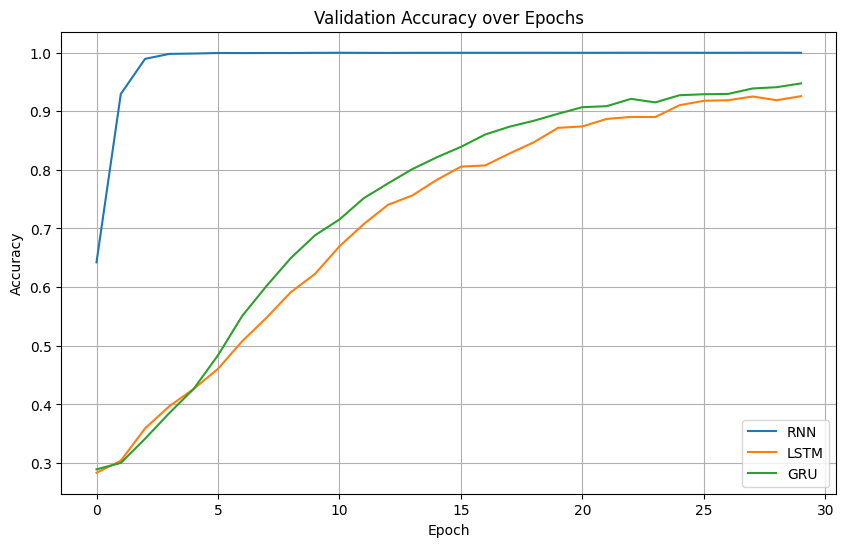

In [15]:
# Plotting
plt.figure(figsize=(10, 6))
for model_type, (_, history) in results.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_type}')
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

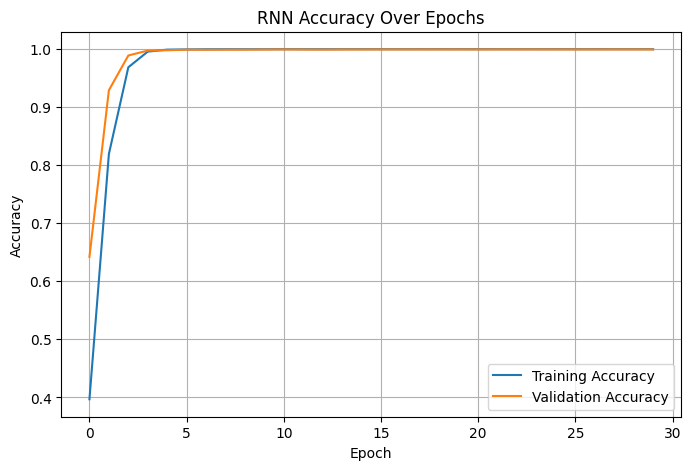

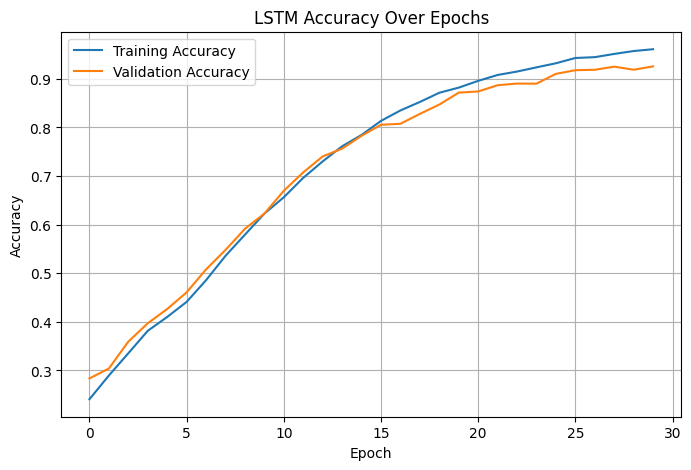

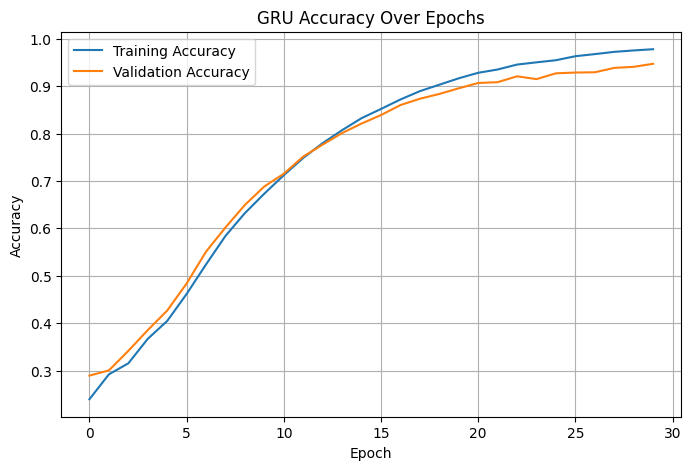

In [16]:
# Plot individual accuracy curves
for model_type, (_, history) in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_type} Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

###  Results & Observations:

Each model was trained and evaluated individually. Accuracy was tracked over 30 epochs and visualized using plots.

* **RNN** showed moderate performance, often plateauing early due to vanishing gradients.
* **LSTM** achieved the highest validation accuracy, thanks to its better handling of long-term dependencies.
* **GRU** also performed well and trained faster, but slightly lagged behind LSTM in overall accuracy.

###  Conclusion:

This assignment demonstrated the effectiveness of using Seq2Seq models for sequence transformation tasks. Among the tested architectures:

* **LSTM** provided the most accurate predictions due to its strong memory retention.
* **GRU** offered a good trade-off between accuracy and training efficiency.
* **RNN** struggled with long-term dependencies but still learned basic patterns.

This experiment highlights the importance of choosing the right recurrent architecture for tasks involving sequence learning.
